In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import from custom package
from auxFuns.EDA import *

In [3]:
# os.chdir('..')

# 1. Loading the data and summary function

In [5]:
datasets_path = os.getcwd() + '/datasets/raw'

In [6]:
rsv_predictors_phase1_df = pd.read_csv(datasets_path + '/rsv_predictors_df_phase1_v3.csv')
rsv_predictors_phase1_df = make_it_categorical(rsv_predictors_phase1_df)

In [73]:
summary_function_rsv(rsv_predictors_phase1_df)

                CCI          sine        cosine    n_symptoms  n_encounters  \
count  86659.000000  86659.000000  8.665900e+04  86659.000000  86659.000000   
mean       2.360297      0.305377  3.863281e-01      2.145963      4.697642   
std        2.432005      0.639752  5.901029e-01      1.702432      6.967793   
min        0.000000     -1.000000 -1.000000e+00      0.000000      1.000000   
25%        0.000000     -0.239316 -1.608123e-16      1.000000      1.000000   
50%        2.000000      0.464723  5.680647e-01      2.000000      2.000000   
75%        4.000000      0.885456  8.854560e-01      3.000000      5.000000   
max       14.000000      1.000000  1.000000e+00     13.000000     79.000000   

       prev_positive_rsv  tendency_to_positivity  previous_test_daydiff  \
count       86659.000000            86659.000000           8.665900e+04   
mean            0.061159                0.030626           3.788330e+05   
std             0.394196                0.127717           4.77

# 2. Plots of positivity and evaluation of correlations

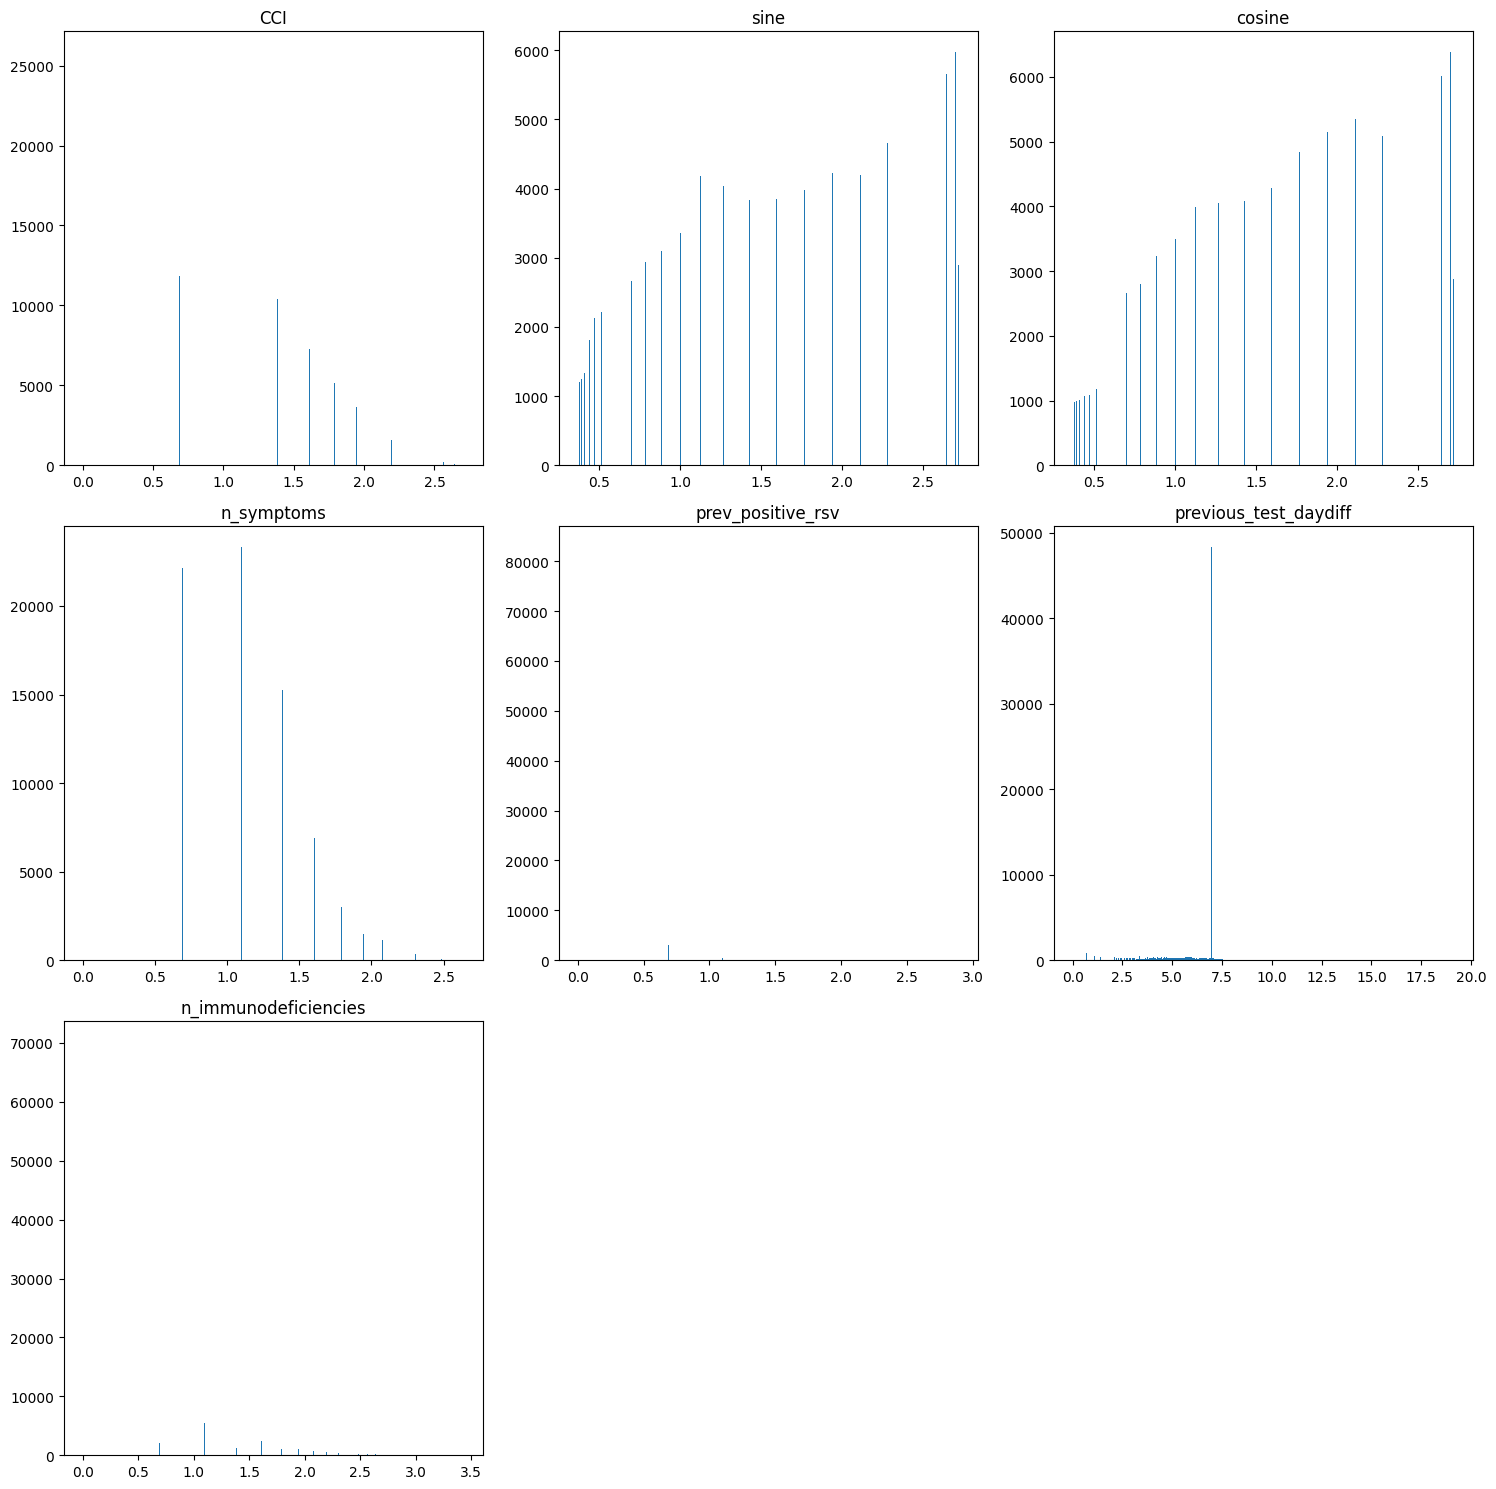

In [26]:
# Start by evaluating the distribution of specific columns
columns_to_inspect = ['CCI', 'sine','cosine', 'n_symptoms', 
                      'prev_positive_rsv', 'previous_test_daydiff', 'n_immunodeficiencies']

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten() # axes are flattened to be able to iterate over them

for i, col in enumerate(columns_to_inspect):
    # if col == "sine" or col =="cosine":
    #     data = np.exp(rsv_predictors_phase1_df[col])
    # else:
    #     data = np.log(rsv_predictors_phase1_df[col] + 1)

    data = rsv_predictors_phase1_df[col]
    axs[i].hist(data, bins=500)  
    axs[i].set_title(col)

# Sanity check: eliminate all extra axes
for j in range(i+1, 9):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

# 3. Evaluate positivity within a short period of time
- Tests in the same day and same patient
- Tests in the same week (and same patient)

In [74]:
rsv_predictors_phase1_df['index_date'] = pd.to_datetime(rsv_predictors_phase1_df['index_date']).dt.date

In [159]:
# I want to see (same Day)
# a) how many tests are taken at the same day and same patient 
# b) how many have i) positive-positive, ii) negative-negative, iii) negative-positive

# Take only those records having more than one test that day
more_one_rsv_test_df = (
    rsv_predictors_phase1_df.loc[rsv_predictors_phase1_df['n_tests_that_day'] == 2, 
                                 ['patient_id', 'index_date', 'RSV_test_result']]
                                 )

more_one_rsv_test_df.shape # 1202 records, i.e. 601 test records the same day

(more_one_rsv_test_df['RSV_test_result'] == 'Positive').sum() # 601
(more_one_rsv_test_df['RSV_test_result'] == 'Negative').sum() # 601

# It seems that, every time a test is repeated, there exists one negative and positive test

series_grouped = more_one_rsv_test_df.groupby(['patient_id', 'index_date']).apply(aggregate_same_day_test_results)
# This returns a multi-index (patient_id and index_date) pd.Series
# We can reconvert this to a df

df_grouped = series_grouped.reset_index().rename(columns = {0: 'test_combination'})
df_grouped['test_combination'] = pd.Categorical(
    df_grouped['test_combination'], categories = ['NegNeg', 'PosPos', 'PosNeg'])

In [160]:
df_grouped.describe()

,patient_id,index_date,test_combination
count,601,601,601
unique,536,440,1
top,39c750b5343111eeb7ecd9f0ab68ae132df5610a,2018-11-27,PosNeg
freq,12,6,601


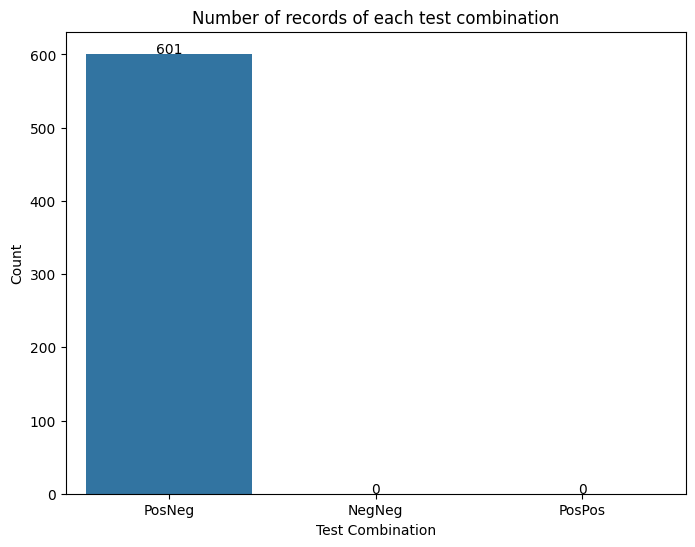

In [178]:
counts = df_grouped['test_combination'].value_counts() # returns a series with index the categories and values the counts per category

counts_df = pd.DataFrame({'test_combination': counts.index, 'count': counts.values})

plt.figure(figsize=(8, 6))
sns.barplot(
    x='test_combination', y='count', data=counts_df, order = ['PosNeg', 'NegNeg', 'PosPos'])
plt.xlabel('Test Combination')
plt.ylabel('Count')
plt.title('Number of records of each test combination')

# Add labels
for i, row in counts_df.iterrows():
    plt.text(i, row['count'], row['count'], color='black', ha="center")
    
plt.show()

Every time a patient is tested twice in a day, they result in a positive-negative combination.

This happens in 601 (out of 2654) positive tests, roughly a 22% of total Positive test. As it is a relevant percentage, a further pre processing step is proposed: cleaning these duplicates

In [188]:
# Test deduplication clean up

one_test_days_df = rsv_predictors_phase1_df.loc[
    rsv_predictors_phase1_df['n_tests_that_day'] == 1]

two_test_days_positive_only_df = rsv_predictors_phase1_df.loc[
    (rsv_predictors_phase1_df['n_tests_that_day'] == 2) & (rsv_predictors_phase1_df['RSV_test_result'] == 'Positive')
]

rsv_predictors_phase1_daysDedup_df = pd.concat([one_test_days_df, two_test_days_positive_only_df], axis = 0)


In [190]:
rsv_predictors_phase1_daysDedup_df['RSV_test_result'].value_counts()


RSV_test_result
Negative    83404
Positive     2654
Name: count, dtype: int64

# 4. Model selection > take features that improve AUC